In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from norse.torch.functional.lif import LIFParameters
from tqdm import tqdm

from cgtasknet.instruments.instrument_pca import PCA
from cgtasknet.net.lifrefrac import SNNLifRefrac
from norse.torch.functional.lif_refrac import LIFRefracParameters

from cgtasknet.net.states import LIFRefracInitState
from cgtasknet.tasks.reduce import DefaultParams, DMTask

input_values = [0, 0.1, 0.2, 0.3, 0.4, 0.49, 0.51, 0.6, 0.7, 0.8, 0.9, 1]
feature_size = 2
output_size = 3
hidden_size = 401
batch_size = 1
neuron_parameters = LIFRefracParameters(
    LIFParameters(
        alpha=torch.as_tensor(100), method="super", v_th=torch.as_tensor(0.65)
    ),
    rho_reset=torch.as_tensor(1),
)
model = SNNLifRefrac(
    feature_size,
    hidden_size,
    output_size,
    neuron_parameters=neuron_parameters,
    tau_filter_inv=500,
    save_states=True,
)
if True:
    model.load_state_dict(
        torch.load(
            "..\models\\only_dm_lif_refrac\\max_accuracy\\_lr_0.001_N_401_number_1990"
        )
    )
init_state = LIFRefracInitState(batch_size, hidden_size)
first_state = init_state.zero_state()
second_state = init_state.random_state()
v_mean = None
number_of_trials = 1
data_save = torch.zeros((0, 1, 2))
for trial in tqdm(range(number_of_trials)):
    v_save = torch.zeros((0, 1, hidden_size))
    for value in range(len(input_values)):
        dmparams = DefaultParams("DMTask").generate_params()
        dmparams["value"] = input_values[value]
        Task = DMTask(dmparams, mode="value")
        data, _ = Task.dataset(1)
        data = torch.from_numpy(data).type(torch.float)
        out, states = model(data, first_state)
        v = []
        s = []
        # i = []
        for j in range(len(states)):
            v.append(states[j].lif.v)
            s.append(states[j].lif.z)
            # i.append(states[j].lif.i)
        v = torch.stack(v).detach()
        v_save = torch.concat((v_save, v), axis=0)
        if trial == 0:
            data_save = torch.concat((data_save, data), axis=0)
    if v_mean is None:
        v_mean = torch.zeros_like(v_save)
    v_mean += v_save
v_mean /= float(number_of_trials)


pca = PCA(3).decompose(v_mean.reshape(v_mean.shape[0], v_mean.shape[2]))


s = torch.stack(s).detach()
s = s.cpu().numpy()

100%|██████████| 1/1 [00:05<00:00,  5.25s/it]


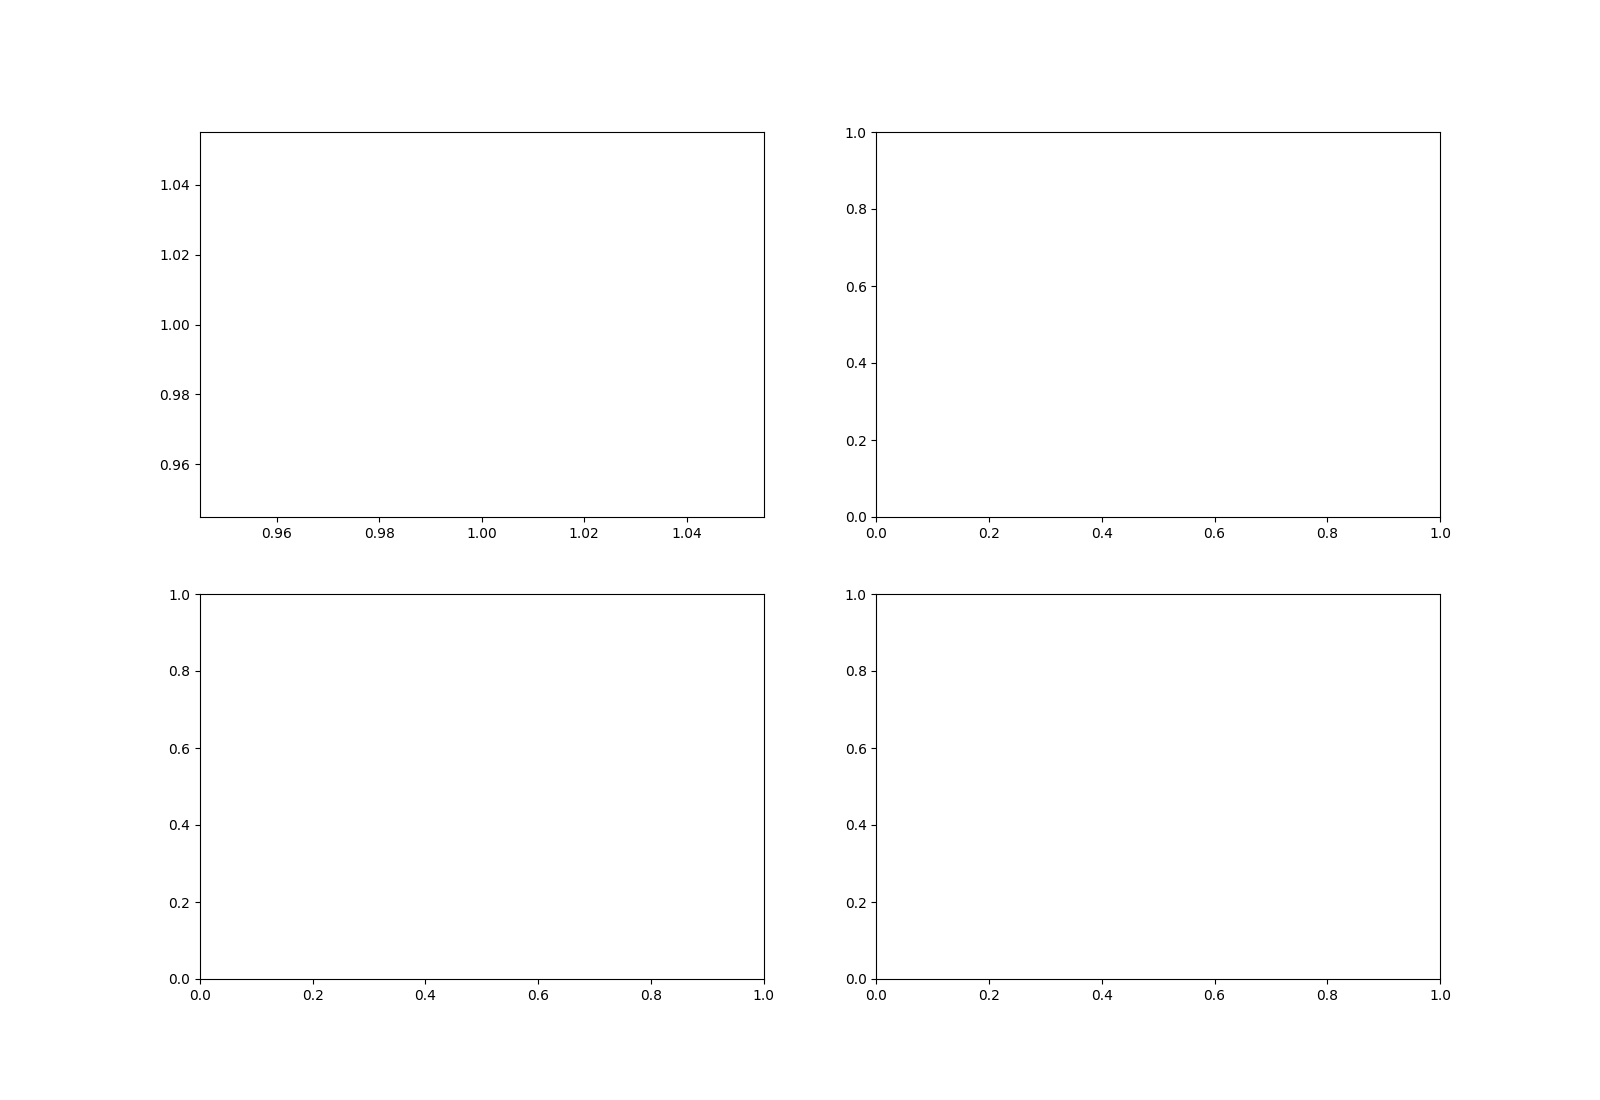

In [2]:
%matplotlib widget
plt.ion
fig = plt.figure(figsize=(16, 11))
ax = fig.add_subplot(221)

ax2 = fig.add_subplot(223)

(line,) = ax.plot(1, 1)
(line2,) = ax.plot(1, 1)
fig.canvas.draw()
fig.canvas.flush_events()

ax3 = fig.add_subplot(222)
ax4 = fig.add_subplot(224)
# plt.tight_layout()

In [3]:
import time

start = 0
step = 70
c = [i for i in range(start, len(pca), step)]


def update():
    for i in range(start, len(pca), step):
        first = 0
        second = 1
        third = 2

        # plt.clf()
        ax.set_xlim(-40, 12)
        ax.set_ylim(-18, 18)

        ax2.set_xlim([0, len(pca)])
        ax2.set_ylim([-0.5, 1.5])
        ax.clear()
        ax2.clear()
        ax3.clear()
        ax4.clear()

        ax.scatter(
            pca.numpy()[start:i, first],
            pca.numpy()[start:i, second],
            cmap="jet",
            c=[j for j in range(i - start)],
            s=2,
        )

        ax2.clear()
        ax2.plot(data_save[:i, 0, 1].numpy(), c="black")

        ax3.plot(pca.numpy()[start:i, first], c="black")
        ax4.plot(pca.numpy()[start:i, second], c="black")

        ax.set_xlabel("$PC_1$")
        ax.set_ylabel("$PC_2$")
        # ax.set_zlabel("$PC_3$")
        ax2.set_xlabel("Time, ms")
        ax2.set_ylabel("Input")
        ax3.set_xlabel("Time, ms")
        ax3.set_ylabel("$PC_1$")
        ax4.set_xlabel("Time, ms")
        ax4.set_ylabel("$PC_2$")

        fig.canvas.draw()
        fig.canvas.flush_events()
        # time.sleep(.001)


# while True:
update()

KeyboardInterrupt: 

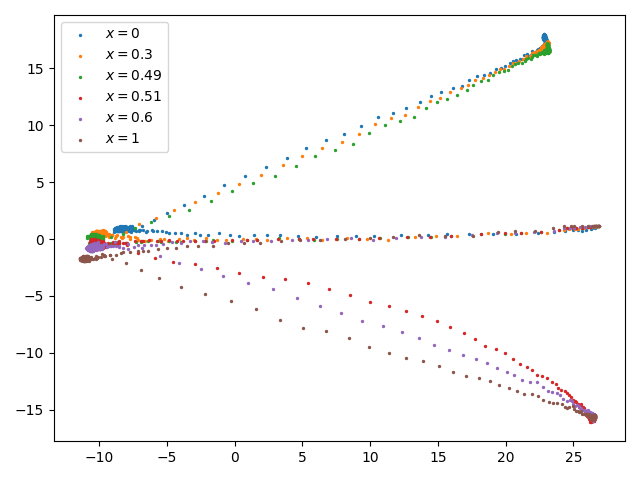

In [4]:
plt.figure()
one_time_trial = int((dmparams["delay"] + dmparams["trial_time"]) / dmparams["dt"])
times_trial = int(len(pca) / one_time_trial)
times = [0, 3, 5, 6, 7, 11]
for i in times:
    plt.scatter(
        pca.numpy()[one_time_trial * i : one_time_trial * (i + 1), 0],
        pca.numpy()[one_time_trial * i : one_time_trial * (i + 1), 1],
        cmap="jet",
        s=2,
        label=f"$x={input_values[i]}$",
    )
plt.legend()
plt.tight_layout()
plt.savefig("главные компоненты несколько значений.pdf")
plt.show()

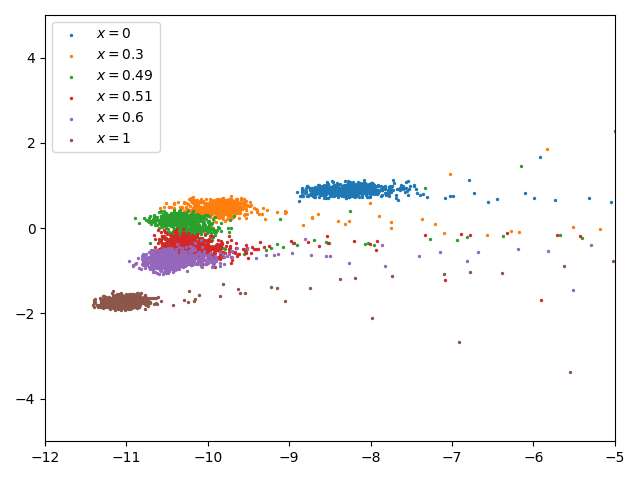

In [6]:
plt.figure()
one_time_trial = int((dmparams["delay"] + dmparams["trial_time"]) / dmparams["dt"])
times_trial = int(len(pca) / one_time_trial)
times = [0, 3, 5, 6, 7, 11]
for i in times:
    plt.scatter(
        pca.numpy()[one_time_trial * i : one_time_trial * (i + 1), 0],
        pca.numpy()[one_time_trial * i : one_time_trial * (i + 1), 1],
        cmap="jet",
        s=2,
        label=f"$x={input_values[i]}$",
    )
plt.xlim([-12, -5])
plt.ylim([-5, 5])
plt.legend()
plt.tight_layout()
plt.savefig("главные компоненты несколько значений_зум_фиксации.pdf")
plt.show()

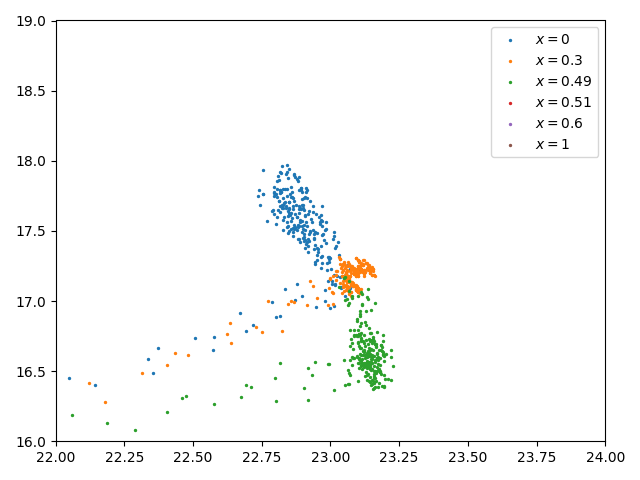

In [8]:
plt.figure()
one_time_trial = int((dmparams["delay"] + dmparams["trial_time"]) / dmparams["dt"])
times_trial = int(len(pca) / one_time_trial)
times = [0, 3, 5, 6, 7, 11]
for i in times:
    plt.scatter(
        pca.numpy()[one_time_trial * i : one_time_trial * (i + 1), 0],
        pca.numpy()[one_time_trial * i : one_time_trial * (i + 1), 1],
        cmap="jet",
        s=2,
        label=f"$x={input_values[i]}$",
    )
plt.xlim([22, 24])
plt.ylim([16, 19])
plt.legend()
plt.tight_layout()
plt.savefig("главные компоненты несколько значений_зум_1_отклика (сверху).pdf")
plt.show()

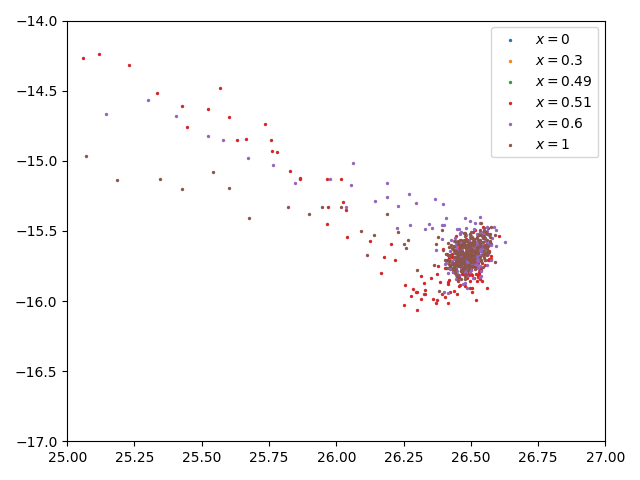

In [13]:
plt.figure()
one_time_trial = int((dmparams["delay"] + dmparams["trial_time"]) / dmparams["dt"])
times_trial = int(len(pca) / one_time_trial)
times = [0, 3, 5, 6, 7, 11]
for i in times:
    plt.scatter(
        pca.numpy()[one_time_trial * i : one_time_trial * (i + 1), 0],
        pca.numpy()[one_time_trial * i : one_time_trial * (i + 1), 1],
        cmap="jet",
        s=2,
        label=f"$x={input_values[i]}$",
    )
plt.xlim([25, 27])
plt.ylim([-17, -14])
plt.legend()
plt.tight_layout()
plt.savefig("главные компоненты несколько значений_зум_2_отклика (снизу).pdf")
plt.show()

In [50]:
plt.scatter(
    pca.numpy()[:, 0],
    pca.numpy()[:, 1],
    cmap="jet",
    s=2,
)

In [48]:
times_trial

12

In [28]:
data_save.shape

torch.Size([0, 1, 2])

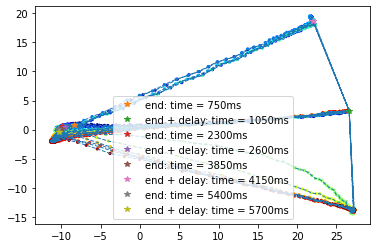

In [19]:
cmap = np.arange(0, len(v_mean))
first = 0
second = 1
plt.plot(pca.numpy()[:, first], pca.numpy()[:, second], "--", linewidth=1)
plt.scatter(pca.numpy()[:, first], pca.numpy()[:, second], c=cmap, cmap="jet", s=5)


trialstop = 750
delay = 300
delay_beetween = 500
time = trialstop
for i in range(4):

    plt.plot(
        pca.numpy()[time, first],
        pca.numpy()[time, second],
        "*",
        label=rf"end: time = {time}ms",
    )
    time += delay
    plt.plot(
        pca.numpy()[time, first],
        pca.numpy()[time, second],
        "*",
        label=rf"end + delay: time = {time}ms",
    )

    time += delay_beetween + trialstop


plt.legend()
plt.show()

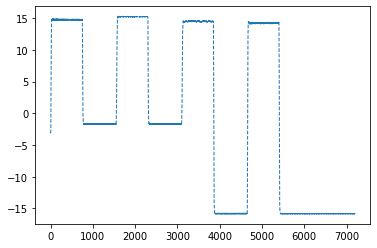

In [17]:
plt.plot(pca.numpy()[:, 0], "--", linewidth=1)

plt.show()

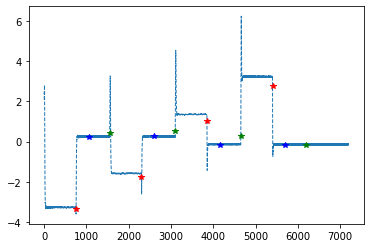

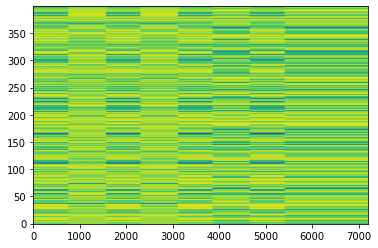

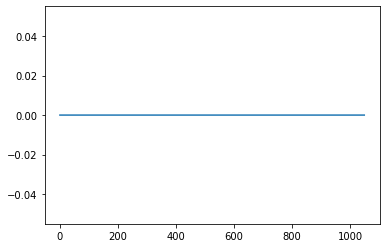

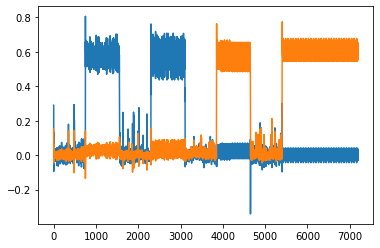

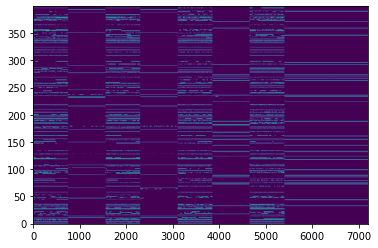

In [18]:
pca_show = 2
plt.plot(pca.numpy()[:, pca_show], "--", linewidth=1)
trialstop = 750
delay = 300
delay_beetween = 500
time = trialstop
for i in range(4):

    plt.plot([time], pca.numpy()[time, pca_show], "*", c="r")
    time += delay
    plt.plot(
        [time],
        pca.numpy()[time, pca_show],
        "*",
        c="b",
    )
    time += delay_beetween
    plt.plot(
        [time],
        pca.numpy()[time, pca_show],
        "*",
        c="g",
    )
    time += trialstop
plt.show()

plt.imshow(v_mean.numpy()[:, 0, :].T, aspect="auto", origin="lower")
plt.show()

inputs, target_out = Task.dataset(1)

plt.plot(inputs[:, 0, 1])
plt.show()

# plt.plot(out[:, 0, 0])
plt.plot(out[:, 0, 1])
plt.plot(out[:, 0, 2])
plt.show()


plt.imshow(s[:, 0, :].T, aspect="auto", origin="lower", vmax=0.8)
plt.show()